In [1]:
import imutils
from imutils.video import FPS
import cv2
import numpy as np
import tensorflow as tf
from PIL import Image

In [2]:
MODEL = tf.keras.Sequential([
            tf.keras.layers.Conv2D(32,input_shape = (112,112,3),kernel_size=(3, 3),activation='relu'),
            tf.keras.layers.Conv2D(64,kernel_size=(3,3),strides = 1,padding = 'valid',activation = 'relu'),
            tf.keras.layers.Conv2D(64,kernel_size=(3,3),strides = 1,padding = 'valid',activation = 'relu'),
            tf.keras.layers.Conv2D(64,kernel_size=(3,3),strides = 1,padding = 'valid',activation = 'relu'),
            tf.keras.layers.Conv2D(64,kernel_size=(3,3),strides = 1,padding = 'valid',activation = 'relu'),
            tf.keras.layers.Conv2D(128,kernel_size=(3,3),strides = 1,padding = 'valid',activation = 'relu'),
            tf.keras.layers.Conv2D(128,kernel_size=(3,3),strides = 1,padding = 'valid',activation = 'relu'),
            tf.keras.layers.Conv2D(128,kernel_size=(3,3),strides = 1,padding = 'valid',activation = 'relu'),
            tf.keras.layers.Conv2D(256,kernel_size=(3,3),strides = 1,padding = 'valid',activation = 'relu'),
            tf.keras.layers.MaxPool2D(pool_size=(2, 2),strides=2 ,padding='valid'),
            tf.keras.layers.MaxPool2D(pool_size=(2, 2),strides=2 ,padding='valid'),
            tf.keras.layers.MaxPool2D(pool_size=(2, 2),strides=2 ,padding='valid'),
            tf.keras.layers.MaxPool2D(pool_size=(2, 2),strides=1 ,padding='valid'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(units=1024,activation='relu',use_bias=True),
            tf.keras.layers.Dense(units=136,use_bias=True),
])
MODEL.load_weights('MODEL.h5')

In [3]:
cv2.__version__

'4.2.0'

In [4]:
def sun_glass(frame,pts):
    x_s = int(pts[17, 0]) - 13
    y_s = int(pts[17, 1])
    h_s = int(abs(pts[27,1] - pts[34,1])) + 14
    w_s = int(abs(pts[17,0] - pts[26,0])) + 31
    #print(w_s,h_s)
    sunglasses = cv2.imread('sunglasses.png', cv2.IMREAD_UNCHANGED)
    new_sunglasses =  cv2.resize(sunglasses, (w_s, h_s), interpolation = cv2.INTER_CUBIC)
    select = frame[y_s:y_s+h_s,x_s:x_s+w_s]
    ind = np.argwhere(new_sunglasses[:,:,3] > 0)
    for i in range(3):
        select[ind[:,0],ind[:,1],i] = new_sunglasses[ind[:,0],ind[:,1],i]    
    frame[y_s:y_s+h_s,x_s:x_s+w_s] = select
    return frame

def hatter(frame,pts):
    x = int(pts[0, 0]) - 8 
    y = int(pts[19, 1]) 
    h = int(abs(pts[19,1] - pts[8,1])) + 50
    w = int(abs(pts[0,0] - pts[16,0])) + 180
    x = x-104
    y = y-h + 15
    hat = cv2.imread('straw_hat.png', cv2.IMREAD_UNCHANGED)
    new_hat =  cv2.resize(hat, (w, h), interpolation = cv2.INTER_CUBIC)
    select = frame[y:y+h,x:x+w]
    ind = np.argwhere(new_hat[:,:,3] > 0)
    for i in range(3):
        select[ind[:,0],ind[:,1],i] = new_hat[ind[:,0],ind[:,1],i]    
    frame[y:y+h,x:x+w] = select
    return frame

def mstche(frame,pts):
    x = int(pts[2, 0])+ 17
    y = int(pts[2, 1]) -4
    h = int(abs(pts[30,1] - pts[57,1])) + 6 
    w = int(abs(pts[48,0] - pts[54,0])) + 30
    mst = cv2.imread('moustache.png', cv2.IMREAD_UNCHANGED)
    new_mst =  cv2.resize(mst, (w, h), interpolation = cv2.INTER_CUBIC)
    select = frame[y:y+h,x:x+w]
    ind = np.argwhere(new_mst[:,:,3] > 0)
    for i in range(3):
        select[ind[:,0],ind[:,1],i] = new_mst[ind[:,0],ind[:,1],i]    
    frame[y:y+h,x:x+w] = select
    return frame

In [14]:
csrt = cv2.TrackerCSRT_create()
BB = None
fps = None
videocapture = cv2.VideoCapture(0)
sunglass = False
mouse = False
straw = False
normal = True
x_origin = 80
y_origin = 200

# intializing the Haarcascade
YOLO = cv2.CascadeClassifier(r'C:\Users\shaur\anaconda3\Lib\site-packages\cv2\data\haarcascade_frontalface_default.xml')

In [15]:
while True:
    frame = videocapture.read()
    frame = frame[1]
    if frame is None:
        break
    (H,V) = frame.shape[0:2]
    gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    faces = YOLO.detectMultiScale(gray,
                                scaleFactor = 1.5,
                                minNeighbors = 5,
                                minSize = (30,30),
                                flags = cv2.CASCADE_SCALE_IMAGE)
    
    
    if BB is not None:
        # console circle
        cv2.circle(frame,(x_origin,y_origin),80,(255,255,255), 1)
        (success, box) = csrt.update(frame)
        if success:
            (x, y, w, h) = [int(v) for v in box]
            #cv2.rectangle(frame, (x, y), (x + w, y + h),(0, 255, 0), 2)
            cv2.circle(frame,(x+w//2,y+h//2),60,(0,255,0),2)
            
            x_diff = (x+w//2) - x_origin
            y_diff = (y+w//2) - y_origin
            #print(x_diff,y_diff)
            if y_diff > 30 :
                sunglass = False
                mouse = False
                straw = False
                normal = True
            if y_diff < -30 :
                sunglass = True
                mouse = False
                straw = False
                normal = False
            if x_diff < -30 :
                sunglass = False
                mouse = False
                straw = True
                normal = False
            if x_diff > 30 :
                sunglass = False
                mouse = True
                straw = False
                normal = False
            
        fps.update()
        fps.stop()
        info = [
            ("FPS", "{:.2f}".format(fps.fps())),
            ("coordinates","{},{}".format(x,y))
        ]
        for (i, (k, v)) in enumerate(info):
            text = "{}: {}".format(k, v)
            cv2.putText(frame, text, (10, H - ((i * 20) + 20)),
                cv2.FONT_HERSHEY_COMPLEX, 0.6, (0, 0, 255), 1)
    
    if sunglass:
        for (x,y,w,h) in faces:
            img = frame[y-75:y+w+75,x-35:x+w+35]
            orig = img.shape
            a = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            i = Image.fromarray(a)
            i = i.resize((112,112))
            i = np.array(i)
            pts = MODEL.predict(i.reshape(1,112,112,3)/255.) * 112
            xe = orig[1] / 112
            ye = orig[0] / 112
            pts = pts.reshape((68,2))
            pts[:,0] = pts[:,0]*xe + (x-35)
            pts[:,1] = pts[:,1]*ye + (y-75) 
            frame = sun_glass(frame,pts)
        #frame = printer(frame,'sunglasses.png')
    elif mouse :
        for (x,y,w,h) in faces:
            img = frame[y-75:y+w+75,x-35:x+w+35]
            orig = img.shape
            a = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            i = Image.fromarray(a)
            i = i.resize((112,112))
            i = np.array(i)
            pts = MODEL.predict(i.reshape(1,112,112,3)/255.) * 112
            xe = orig[1] / 112
            ye = orig[0] / 112
            pts = pts.reshape((68,2))
            pts[:,0] = pts[:,0]*xe + (x-35)
            pts[:,1] = pts[:,1]*ye + (y-75) 
            frame = mstche(frame,pts)
        #frame = printer(frame,'moustache.png')
    elif straw :
        for (x,y,w,h) in faces:
            img = frame[y-75:y+w+75,x-35:x+w+35]
            orig = img.shape
            a = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            i = Image.fromarray(a)
            i = i.resize((112,112))
            i = np.array(i)
            pts = MODEL.predict(i.reshape(1,112,112,3)/255.) * 112
            xe = orig[1] / 112
            ye = orig[0] / 112
            pts = pts.reshape((68,2))
            pts[:,0] = pts[:,0]*xe + (x-35)
            pts[:,1] = pts[:,1]*ye + (y-75) 
            frame = hatter(frame,pts)
        #frame = printer(frame,'straw_hat.png')
    elif normal:
        for (x,y,w,h) in faces: 
            cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,0),2)
    cv2.imshow("Frame", frame)
    key = cv2.waitKey(1) & 0xFF
    
    if key == ord("s"):
        BB = cv2.selectROI("Frame", frame, fromCenter=False, showCrosshair=True)
        csrt.init(frame, BB)
        fps = FPS().start()
    
    elif key == ord("q"):
        break

videocapture.release()
cv2.destroyAllWindows()

In [16]:
videocapture.release()
cv2.destroyAllWindows()

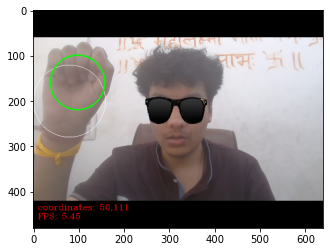

In [17]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))

In [18]:
faces

array([[228, 140, 182, 182]], dtype=int32)

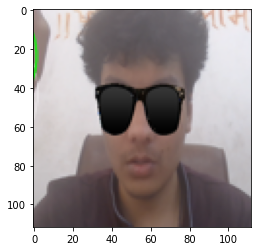

In [19]:
from PIL import Image
a = frame[105:357,153:485] #(y-75:y+75+w) (x-35:x+35+h)
a = cv2.cvtColor(a,cv2.COLOR_BGR2RGB)
i = Image.fromarray(a)
i = i.resize((112,112))
plt.imshow(i)

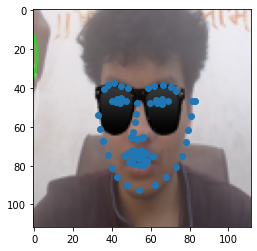

In [20]:
#i = mpimg.imread('test.jpg')
#i = Image.fromarray(i)
#i = i.resize((112,112))
i = np.array(i)

t = MODEL.predict(i.reshape(1,112,112,3)/255.)
plt.imshow(i)
tp = t.reshape(136,1)
tp = tp*112
plt.scatter(tp[0::2],tp[1::2])
plt.show()

In [21]:
tt = np.copy(frame)
for (x,y,w,h) in faces:
    img = tt[y-75:y+w+75,x-35:x+w+35]
    orig = img.shape
    a = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    i = Image.fromarray(a)
    i = i.resize((112,112))
    i = np.array(i)
    pts = MODEL.predict(i.reshape(1,112,112,3)/255.) * 112
    xe = orig[1] / 112
    ye = orig[0] / 112
    pts = pts.reshape((68,2))
    pts[:,0] = pts[:,0]*xe + (x-35)
    pts[:,1] = pts[:,1]*ye + (y-75) 
    tt = mstche(tt,pts)
    tt = hatter(tt,pts)

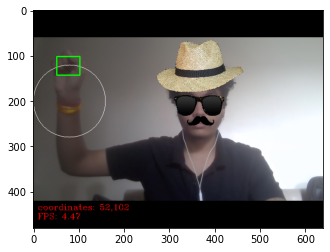

In [12]:
plt.imshow(cv2.cvtColor(tt,cv2.COLOR_BGR2RGB))

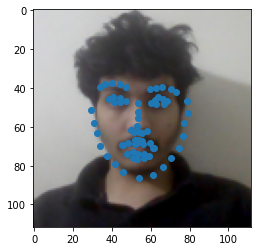

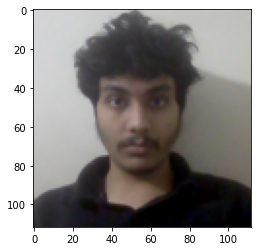

In [9]:
i = mpimg.imread('test_img.jpg')
i = Image.fromarray(i)
i = i.resize((112,112))
i = np.array(i)

t = MODEL.predict(i.reshape(1,112,112,3)/255.)
plt.imshow(i)
tp = t.reshape(136,1)
tp = tp*112
plt.scatter(tp[0::2],tp[1::2])
plt.show()


plt.figure()
plt.imshow(i)